In [6]:
from sklearn.datasets import fetch_california_housing
from sklearn import ensemble

data, target = fetch_california_housing(as_frame=True, return_X_y=True)
data = data[:10000]
target = target[:10000]
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [15]:
import pandas as pd
import numpy as np

# Adding random features
rng = np.random.RandomState(0)
bin_var = pd.Series(rng.randint(0, 1, data.shape[0]), name='rnd_bin')
num_var = pd.Series(np.arange(data.shape[0]), name='rnd_num')
data_with_rnd_feat = pd.concat((data, bin_var, num_var), axis=1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_with_rnd_feat, target,
                                                    random_state=42)

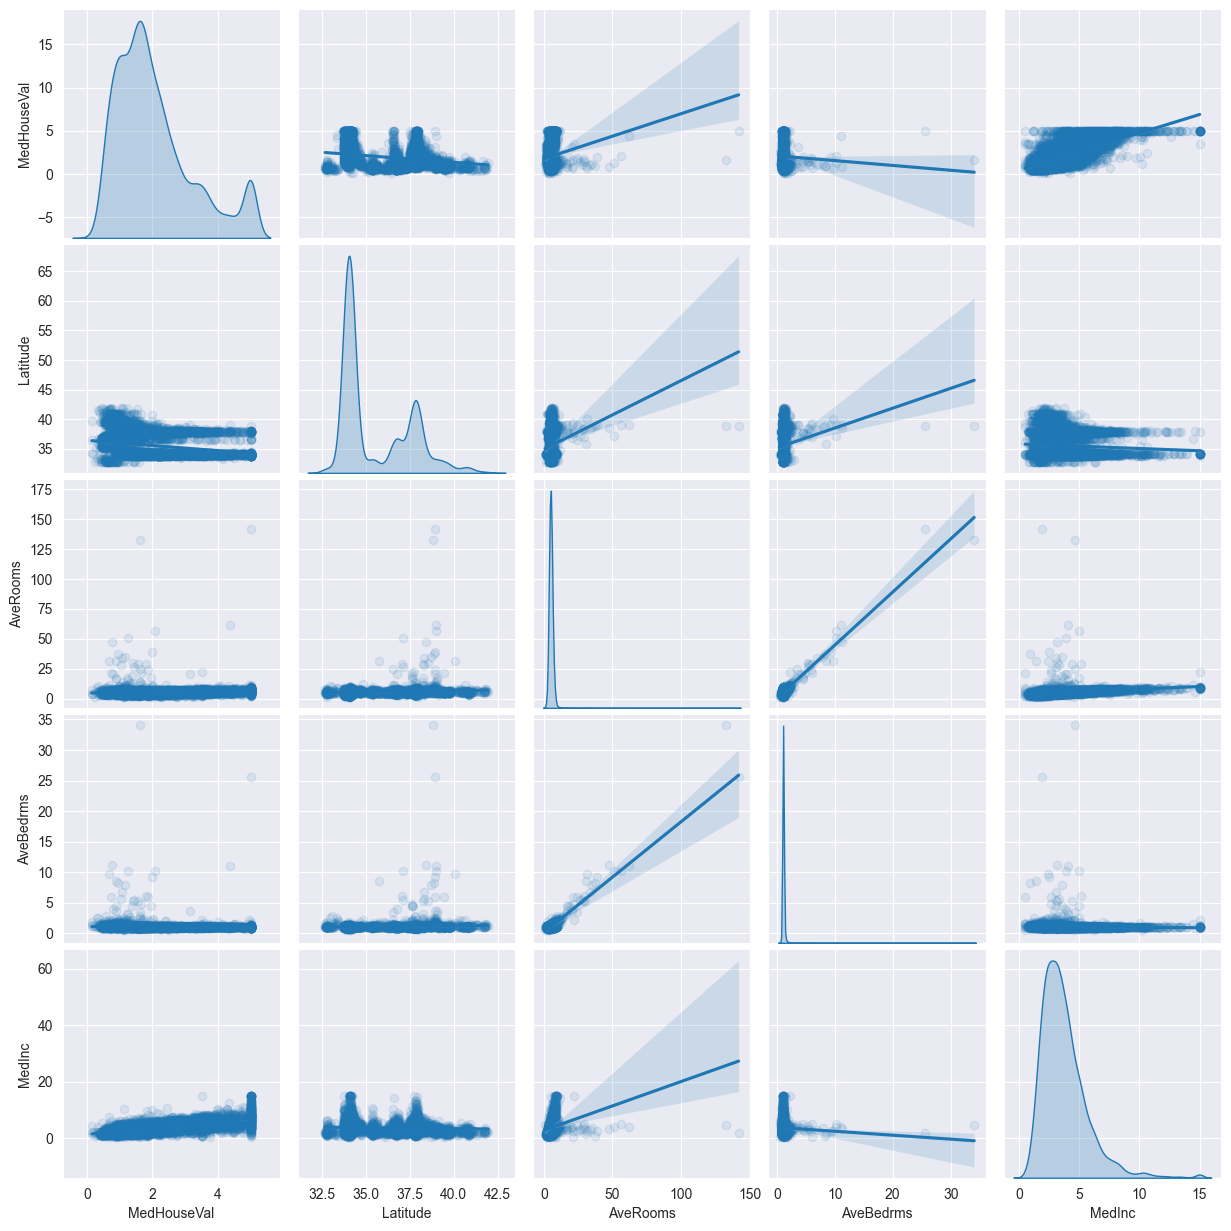

In [16]:
import seaborn as sns

train_dataset = X_train.copy()
train_dataset.insert(0, "MedHouseVal", y_train)
_ = sns.pairplot(
    train_dataset[['MedHouseVal', 'Latitude', 'AveRooms', 'AveBedrms', 'MedInc']],
    kind='reg', diag_kind='kde', plot_kws={'scatter_kws': {'alpha': 0.1}})

In [18]:
model = ensemble.RandomForestRegressor()

model.fit(X_train, y_train)

print(f'model score on training data: {model.score(X_train, y_train)}')
print(f'model score on testing data: {model.score(X_test, y_test)}')

model score on training data: 0.9792283028858351
model score on testing data: 0.8428039405017989


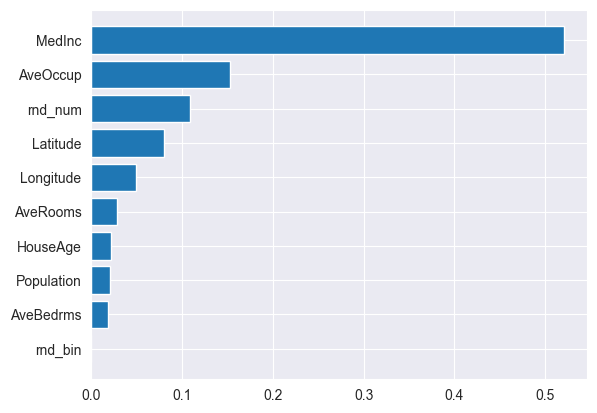

In [21]:
from matplotlib import pyplot as plt

importances = model.feature_importances_

indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

In [22]:
def get_score_after_permutation(model, X, y, curr_feat):
    """ return the score of model when curr_feat is permuted """

    X_permuted = X.copy()
    col_idx = list(X.columns).index(curr_feat)
    # permute one column
    X_permuted.iloc[:, col_idx] = np.random.permutation(
        X_permuted[curr_feat].values)

    permuted_score = model.score(X_permuted, y)
    return permuted_score


def get_feature_importance(model, X, y, curr_feat):
    """ compare the score when curr_feat is permuted """

    baseline_score_train = model.score(X, y)
    permuted_score_train = get_score_after_permutation(model, X, y, curr_feat)

    # feature importance is the difference between the two scores
    feature_importance = baseline_score_train - permuted_score_train
    return feature_importance


curr_feat = 'MedInc'

feature_importance = get_feature_importance(model, X_train, y_train, curr_feat)
print(f'feature importance of "{curr_feat}" on train set is '
      f'{feature_importance:.3}')

feature importance of "MedInc" on train set is 0.667


In [23]:
n_repeats = 10

list_feature_importance = []
for n_round in range(n_repeats):
    list_feature_importance.append(
        get_feature_importance(model, X_train, y_train, curr_feat))

print(
    f'feature importance of "{curr_feat}" on train set is '
    f'{np.mean(list_feature_importance):.3} '
    f'± {np.std(list_feature_importance):.3}')

feature importance of "MedInc" on train set is 0.68 ± 0.0141


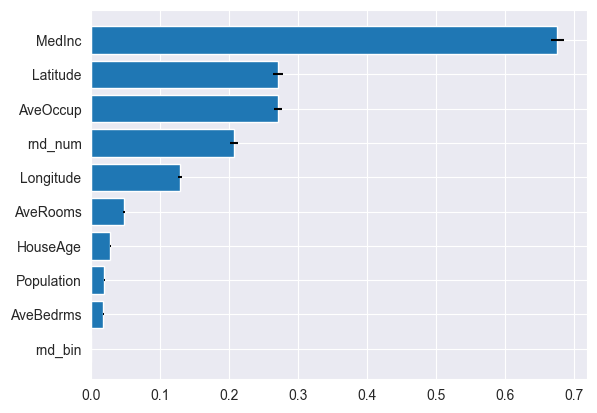

In [25]:
from sklearn.inspection import permutation_importance

def plot_feature_importances(perm_importance_result, feat_name):
    """ bar plot the feature importance """

    fig, ax = plt.subplots()

    indices = perm_importance_result['importances_mean'].argsort()
    plt.barh(range(len(indices)),
             perm_importance_result['importances_mean'][indices],
             xerr=perm_importance_result['importances_std'][indices])

    ax.set_yticks(range(len(indices)))
    _ = ax.set_yticklabels(feat_name[indices])

perm_importance_result_train = permutation_importance(
    model, X_train, y_train, n_repeats=10)

plot_feature_importances(perm_importance_result_train, X_train.columns)